# Maximum Likelihood Estimation (MLE)

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 14
%config InlineBackend.figure_format = 'retina'

# <font color=red>Exercise</font>

An particular protein is activated by depolarizing the cell membrane, and deactivates upon repolarization at an average rate. You measure the time to deactivation for a single molecule following each of 10,000 independent repolarizations (see below). What is your best estimate for the rate of deactivation of the protein?

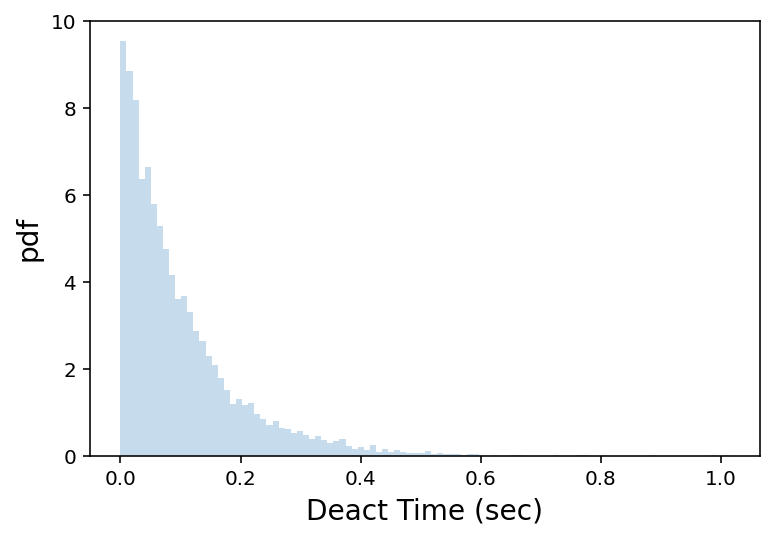

In [122]:
# simulated mock data
deact_sec = st.expon.rvs(loc=0, scale=1/10, size=(10000,))

# rate_per_sec = ...

plt.hist(deact_sec, 100, density=True, alpha=0.25)
t = np.linspace(0, 1, 101)
# plt.plot(t, st.expon.pdf(t, loc=0, scale=1/rate_per_sec))
plt.xlabel('Deact Time (sec)')
plt.ylabel('pdf');

# <font color=darkred>Example</font>

Another protein is activated by depolarizing the cell membrane, and deactivates upon repolarization. You measure the time to deactivation for a single molecule following each of 10,000 independent repolarizations (see below).

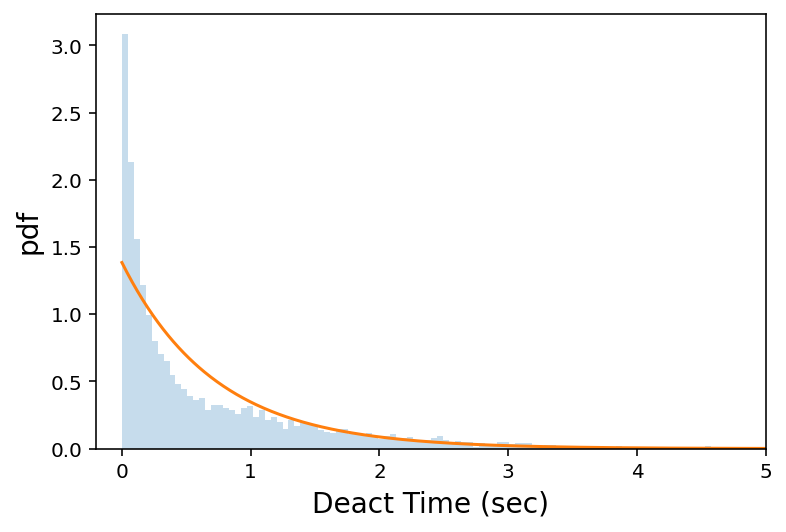

In [121]:
# simulated mock data
deact2_sec = np.concatenate([deact_sec[:3000], st.expon.rvs(loc=0, scale=1, size=(7000,))])

rate2_per_sec = 1 / deact2_sec.mean()

plt.hist(deact2_sec, 200, density=True, alpha=0.25)
t = np.linspace(0, 5, 501)
plt.plot(t, st.expon.pdf(t, loc=0, scale=1/rate2_per_sec))
plt.xlim([-0.2, 5])
plt.xlabel('Deact Time (sec)')
plt.ylabel('pdf');

# <font color=darkred>Example</font>

This protein can deactivate by one of two different pathways with different average rates.

### $pdf = A_1 \left[ 1/\tau_1 exp(-t/\tau_1) \right] + (1-A_1) \left[ 1/\tau_2 exp(-t/\tau_2) \right]$

### $pdf = func(A_1, \tau_1, \tau_2)$

What is your best estimate for the rates and relative frequencies of deactivation along each pathway?

In [83]:
def biexpPdf(data, params):
    A1, tau1, tau2 = params
    A2 = 1 - A1
    exp1 = st.expon(loc=0, scale=tau1)
    exp2 = st.expon(loc=0, scale=tau2)
    return A1 * exp1.pdf(data) + A2 * exp2.pdf(data)

# Joint Probability

# P(A,B) = P(A) P(B)

# Likelihood

### Say you have measured a data sample $x_1, x_2, ..., x_N$

These would be the observed deactivation times in our example.

### If the samples come from a particular $pdf$, then the likelihood that we would make these measurements is the joint probability density of all the measurements.

### $L(x_1, x_2, ..., x_N)=pdf(x_1)pdf(x_2)...pdf(x_N)$

### For a given dataset and a given $pdf$...


### ... our goal is to find the $pdf$ parameters that are most likely to have resulted in our observed dataset.

![](images/likelihood.png)

In [88]:
def likelihood(data, params):
    pdForEachDataPt = biexpPdf(data, params)
    return pdForEachDataPt.prod()

In [89]:
# guess for A1, tau1, tau2
pdfParamsGuess = [0.5, 0.2, 2]

likelihood(deact2_sec, pdfParamsGuess)

inf

In [90]:
likelihood(deact2_sec[:10], pdfParamsGuess)

64.50296188877445

In [91]:
likelihood(deact2_sec[:100], pdfParamsGuess)

7.272579501474419e+24

# Loglikelihood = $log$(Likelihood)

### $L(x_1, x_2, ..., x_N)=pdf(x_1)pdf(x_2)...pdf(x_N)$

### $LL(x_1, x_2, ..., x_N)=log(pdf(x_1))+log(pdf(x_2))+...+log(pdf(x_N))$

In [92]:
def loglikelihood(data, params):
    pdForEachDataPt = biexpPdf(data, params)
    return np.log(pdForEachDataPt).sum()

In [93]:
loglikelihood(deact2_sec, [0.5, 0.2, 2])

-6566.775183326994

In [94]:
loglikelihood(deact2_sec, [0.2, 0.6, 7])

-14195.068146450474

### The first set of parameters are more likely to explain our data.

### Our goal is to find the set of $pdf$ parameters that are the most likely to explain our observed data.

### i.e. the parameters that maximize the loglikelihood of the data.

### <font color=darkred>!!! But we only have a function that minimizes things.</font>

### <font color=red>What should we do?</font>

### Minimize the negative loglikelihood!

In [95]:
def negloglikelihood(data, params):
    pdForEachDataPt = biexpPdf(data, params)
    return -np.log(pdForEachDataPt).sum()

### However we vary the $pdf$ parameters, our data never changes.

### For minimization, we need a cost function whose input is only the $pdf$ parameters that we wish to optimize.

### Given a particular $pdf$, we are searching for the parameters that are most likely to have resulted in our observed data.

In [128]:
def cost(params):
    return negloglikelihood(deact2_sec, params)

In [97]:
# A1, tau1, tau2
start = [0.5, 0.2, 2]
bnds = [(0, 1), (0.01, 10), (0.1, 100)]
result = opt.minimize(cost, start, method='slsqp', bounds=bnds)

result

     fun: 5854.36440022979
     jac: array([ 0.0010376 ,  0.0020752 , -0.00073242])
 message: 'Optimization terminated successfully'
    nfev: 71
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([0.28715783, 0.09625947, 0.97706393])

In [98]:
A1, tau1, tau2 = result.x

Note that these are close to the values that I used to generate the samples:

    A1 = 0.3, tau1 = 0.1, tau2 = 1

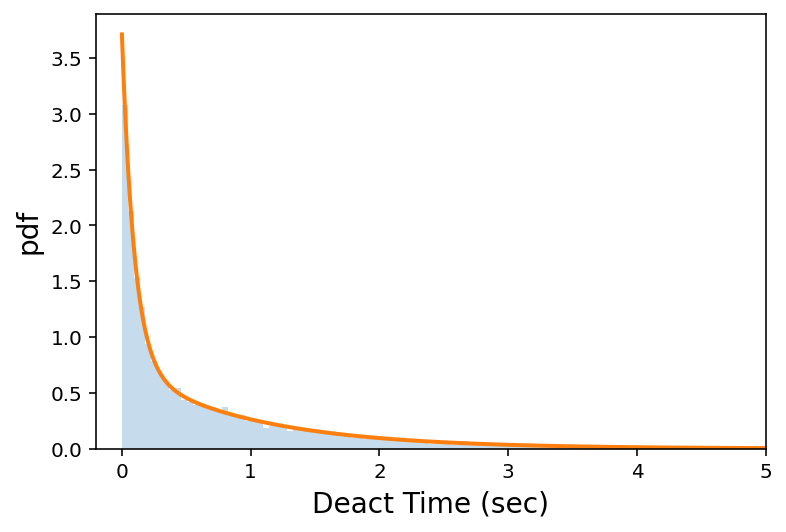

In [120]:
plt.hist(deact2_sec, 200, density=True, alpha=0.25)
t = np.linspace(0, 5, 501)
plt.plot(t, biexpPdf(t, [A1, tau1, tau2]), lw=2)
plt.xlim([-0.2, 5])
plt.xlabel('Deact Time (sec)')
plt.ylabel('pdf');

In [82]:
print(f"Deactivation along pathway 1 occurs at {1/tau1:.1f} per second.")
print(f"Deactivation along pathway 2 occurs at {1/tau2:.1f} per second.")
print(f"Pathways 1 and 2 are traversed {A1*100:.0f}% and {(1-A1)*100:.0f}% of the time, respectively.")

Deactivation along pathway 1 occurs at 10.4 per second.
Deactivation along pathway 2 occurs at 1.0 per second.
Pathways 1 and 2 are traversed 29% and 71% of the time, respectively.


# <font color=red>Exercise</font>

A single ion channel transitions between a closed and an open state. From the histogram of current amplitudes (pA) given below, estimate the single channel current and the average probability that it is either closed or open.

![Single Channel Recording](images/single_channel.png)

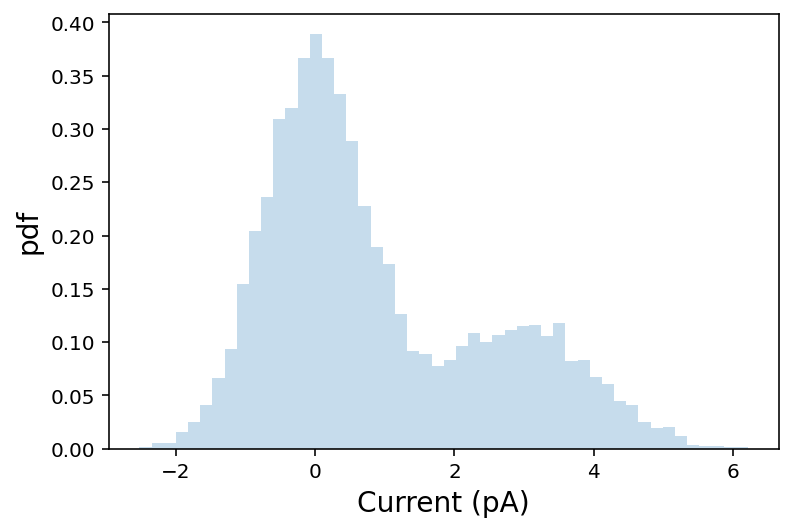

In [127]:
# simulated mock data
current_pA = np.concatenate([st.norm.rvs(0, 0.75, size=(7000,)),
                             st.norm.rvs(3, 1, size=(3000,))])

plt.hist(current_pA, 50, density=True, alpha=0.25)
plt.xlabel('Current (pA)')
plt.ylabel('pdf');

In [ ]:
def twoGaussPdf(data, params):
    ...

def negloglikelihood(data, params):
    ...

def cost(params):
    ...

start = [...]  # initial guess for params
bnds = [...]  # param bounds
result = opt.minimize(cost, start, method='slsqp', bounds=bnds)

result

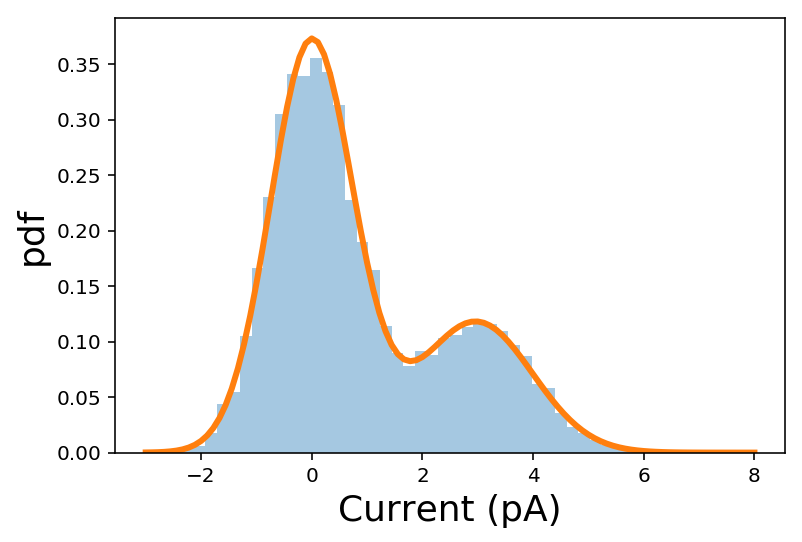

In [34]:
plt.hist(current_pA, 50, density=True, alpha=0.25)
I = np.linspace(-3, 8, 100)
plt.plot(I, twoGaussPdf(I, result.x), lw=3)
plt.xlabel('Current (pA)')
plt.ylabel('pdf');

In [35]:
A1, mu1, sd1, mu2, sd2 = result.x
A2 = 1 - A1

if mu2 < mu1:
    A1, mu1, sd1, A2, mu2, sd2 = A2, mu2, sd2, A1, mu1, sd1

print(f"Single channel current is {mu2 - mu1 :.2f} pA")
print(f"Closed probability is {A1 :.2f}")
print(f"Open probability is {A2 :.2f}")

Single channel current is 2.96 pA
Closed probability is 0.70
Open probability is 0.30
